<a href="https://colab.research.google.com/github/Bathalaxxx/Training-Codes-Repository-EJGP-/blob/main/Quant_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Current Model

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


The best model is XGBoost with a MAPE of 0.05
Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Current price as of 2024-08-01 15:5

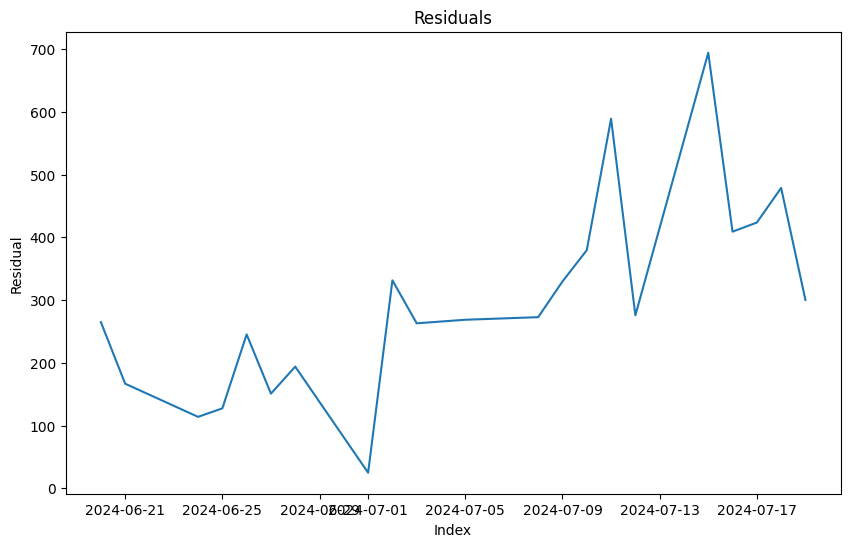

[*********************100%%**********************]  1 of 1 completed

Actual vs Forecast MAPE for the last 10 trading days: 0.07
Bias correction factor applied: 300.15
Corrected forecast for today and the next 10 trading days:
2024-08-02: 5455.31 (Long)
2024-08-05: 5671.81 (Long)
2024-08-06: 5517.18 (Short)
2024-08-07: 5564.36 (Long)
2024-08-08: 5367.12 (Short)
2024-08-09: 5463.39 (Long)


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define date range
end_date = datetime.today() - timedelta(days=10)
start_date = end_date - timedelta(days=5*30)  # Approximate 5 months

# Load data
data = yf.download('^GSPC', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

# Feature and target
data['Adj Close Shifted'] = data['Adj Close'].shift(-1)
data = data.dropna()
X = data[['Volume']]
y = data['Adj Close Shifted']

# Train-test split chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost": XGBRegressor()
}

# Train models and calculate performance metrics
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mape = mean_absolute_percentage_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mae = mean_absolute_error(y_test, predictions)
    results[name] = {'MAPE': mape, 'RMSE': rmse, 'MAE': mae}

# Select the best model
best_model_name = min(results, key=lambda k: results[k]['MAPE'])
best_model = models[best_model_name]

# Describe the chosen model's parameters
model_parameters = best_model.get_params()

# Forecast for today and the next 10 trading days
forecast_dates = []
forecast_start_date = datetime.today()
for _ in range(15):  # Forecast for today + next 10 days
    if forecast_start_date.weekday() < 5:  # Monday to Friday are trading days
        forecast_dates.append(forecast_start_date.strftime('%Y-%m-%d'))
    forecast_start_date += timedelta(days=1)

# For forecasting, use the latest data available up to today
forecast_data = yf.download('^GSPC', start=start_date.strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
forecast_X = scaler.transform(forecast_data[['Volume']][-11:])
forecast_predictions = best_model.predict(forecast_X)

# Get current price
current_price_data = yf.download('^GSPC', period='1d', interval='1m')
current_price = current_price_data['Adj Close'].iloc[-1]
current_datetime = current_price_data.index[-1]

# Output the best model and MAPE
print(f"The best model is {best_model_name} with a MAPE of {results[best_model_name]['MAPE']:.2f}")
print(f"Model Parameters: {model_parameters}")
print(f"Current price as of {current_datetime}: {current_price:.2f}")
print(f"Forecast for today and the next 10 trading days:")

previous_price = current_price  # Use the current price as the initial previous price

for date, prediction in zip(forecast_dates, forecast_predictions):
    position = "Long" if prediction > previous_price else "Short"
    print(f"{date}: {prediction:.2f} ({position})")
    previous_price = prediction

# Residual Analysis
y_test_pred = best_model.predict(X_test_scaled)
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()

# Forecast vs Actual for the last 10 trading days
actual_start_date = datetime.today() - timedelta(days=20)
actual_end_date = datetime.today() - timedelta(days=10)
actual_data = yf.download('^GSPC', start=actual_start_date.strftime('%Y-%m-%d'), end=actual_end_date.strftime('%Y-%m-%d'))

# Ensure we have enough actual data points
if len(actual_data) >= 10:
    actual_prices = actual_data['Adj Close'].values[-10:]
else:
    actual_prices = actual_data['Adj Close'].values

# Ensure forecast and actual data are of the same length
min_length = min(len(actual_prices), len(forecast_predictions))
actual_prices = actual_prices[-min_length:]
forecast_predictions = forecast_predictions[-min_length:]

mape_actual_vs_forecast = mean_absolute_percentage_error(actual_prices, forecast_predictions)

print(f"Actual vs Forecast MAPE for the last 10 trading days: {mape_actual_vs_forecast:.2f}")

# Apply correction factor if needed
bias_correction = np.mean(residuals)
corrected_forecast_predictions = forecast_predictions + bias_correction

print(f"Bias correction factor applied: {bias_correction:.2f}")
print(f"Corrected forecast for today and the next 10 trading days:")

previous_price = current_price  # Reset previous price for corrected forecast

for date, prediction in zip(forecast_dates, corrected_forecast_predictions):
    position = "Long" if prediction > previous_price else "Short"
    print(f"{date}: {prediction:.2f} ({position})")
    previous_price = prediction